# Preprocessing

In [1]:
import pandas as pd

In [2]:
train_data = pd.read_csv("Train.csv", sep=',')
test_data = pd.read_csv("Test.csv", sep=',')

In [3]:
#separating instance and label for Train
X_train_raw = [x[0] for x in train_data[['text']].values]
Y_train = [x[0] for x in train_data[['sentiment']].values]

#check the result
print("Train length:",len(X_train_raw))

#separating instance and label for Test
X_test_raw = [x[0] for x in test_data[['text']].values]

#check the result
print("Test length:",len(X_test_raw))

Train length: 21802
Test length: 6099


In [4]:
#Let's see one example tweet
print(X_train_raw[1])

 is anybody going to the radio station tomorrow to see shawn? me and my friend may go but we would like to make new friends/meet there (:	


## Data cleaning

In [5]:
import unidecode
import contractions
import string
from bs4 import BeautifulSoup
import nltk
#nltk.download()
from nltk.corpus import stopwords

from nltk.corpus import wordnet

from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

In [6]:
X_train_clean = []


table = str.maketrans('', '', string.digits)

stop_words = set(stopwords.words('english'))

lemma = WordNetLemmatizer()


for i in range (len(X_train_raw)):
    #remove unnacessary symbles
    soup = BeautifulSoup(X_train_raw[i], "html.parser")
    temp = soup.get_text(separator=" ")
    
    #remove accented characters
    temp = unidecode.unidecode(temp)
    
    #remove contractions
    temp = contractions.fix(temp)

    #remove number
    temp = temp.translate(table)
    
    #remove punctuations
    temp = temp.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation)))

    #remove stop words
    word_tokens = word_tokenize(temp)
    filtered_sentence = []
    for w in word_tokens:
        if w not in stop_words:
            filtered_sentence.append(w)
            
    temp = " ".join(filtered_sentence)
    
    
    #lemmatization
    def pos_tagger(nltk_tag):
        if nltk_tag.startswith('J'):
            return wordnet.ADJ
        elif nltk_tag.startswith('V'):
            return wordnet.VERB
        elif nltk_tag.startswith('N'):
            return wordnet.NOUN
        elif nltk_tag.startswith('R'):
            return wordnet.ADV
        else:         
            return None
        
    pos_tagged = nltk.pos_tag(nltk.word_tokenize(temp)) 
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tagged))
    lemmatized= []
    for word, tag in wordnet_tagged:
        if tag is None:
            lemmatized.append(word)
        else:       
            lemmatized.append(lemma.lemmatize(word, tag))
    temp = " ".join(lemmatized)
    
    
    #remove extra space
    temp = " ".join(temp.strip().split())
    
    #conver to lower
    temp = temp.lower()
    
    X_train_clean.append(temp)
    

## Split data

### Random hold-out

In [7]:
import numpy as np
from sklearn.model_selection import train_test_split

In [8]:
X_train_sup, X_test_sup, y_train_sup, y_test_sup = train_test_split(X_train_clean, Y_train, test_size = 0.28, random_state = 42)
len(X_test_sup)

6105

## Vectorization

### TFIDF

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [10]:
#combine words
tfidf_vectorizer2 = TfidfVectorizer(analyzer = 'word', ngram_range = (1, 2))
X_train_tfidf2 = tfidf_vectorizer2.fit_transform(X_train_sup)
X_test_tfidf2 = tfidf_vectorizer2.transform(X_test_sup)

print("Train feature space size (using TFIDF):",X_train_tfidf2.shape)
print("Test feature space size (using TFIDF):",X_test_tfidf2.shape)

Train feature space size (using TFIDF): (15697, 157260)
Test feature space size (using TFIDF): (6105, 157260)


In [11]:
tfidf_vectorizer = TfidfVectorizer(analyzer = 'word')
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_sup)
X_test_tfidf = tfidf_vectorizer.transform(X_test_sup)
print("Train feature space size (using TFIDF):",X_train_tfidf.shape)
print("Test feature space size (using TFIDF):",X_test_tfidf.shape)

Train feature space size (using TFIDF): (15697, 30693)
Test feature space size (using TFIDF): (6105, 30693)


## Feature Selection

### SelectKBest

In [12]:
from sklearn.feature_selection import SelectKBest, chi2

In [13]:
selector = SelectKBest(chi2, k = 8000)
X_train_select = selector.fit_transform(X_train_tfidf2, y_train_sup)
X_test_select = selector.transform(X_test_tfidf2)
print(X_train_select.shape, X_test_select.shape)

(15697, 8000) (6105, 8000)


## Modelling

### plot

In [14]:
import matplotlib.pyplot as plt
import collections
import seaborn as sns

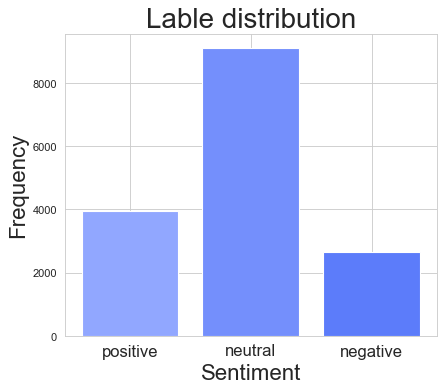

In [15]:
sns.set_style("whitegrid")

plt.figure(figsize=(6,5), dpi=80)
cnt = dict(collections.Counter(y_train_sup))
lb = ['positive', 'neutral', 'negative']
colors = ["#91a7ff", "#748ffc", "#5c7cfa"]
data = [cnt["positive"], cnt["neutral"], cnt["negative"]]
plt.bar(lb, data, color = colors)
plt.xlabel("Sentiment", fontsize = 20)
plt.ylabel('Frequency', fontsize = 20)
plt.xticks(fontsize = 15)
plt.title("Lable distribution", fontsize = 25)
plt.show()

### Baseline

In [16]:
from sklearn.dummy import DummyClassifier

In [17]:
dum_clf = DummyClassifier(strategy = "most_frequent")
dum_md = dum_clf.fit(X_train_select, y_train_sup)
dum_md.score(X_test_select, y_test_sup)

0.5823095823095823

### Grid Search

In [18]:
from sklearn.model_selection import GridSearchCV

### Naive Bayese

In [19]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

In [20]:
acc_metrics = pd.DataFrame(columns = ["Train accuracy", "Validation accuracy"], index = ["Naive bayese", "SVM C = 3","SVM C = 1", "Stacking"])

In [77]:
hyperparams = {
    "alpha" : [0.5, 1, 1.5, 2],
    "fit_prior":[True, False],
}

In [78]:
model = MultinomialNB()
grid_search = GridSearchCV(estimator = model, param_grid = hyperparams, cv = 5, n_jobs = -1, verbose = 3)
grid_search.fit(X_train_select, y_train_sup)
grid_search.best_params_

Fitting 5 folds for each of 8 candidates, totalling 40 fits


{'alpha': 0.5, 'fit_prior': True}

In [21]:
NB_clf = MultinomialNB(alpha=0.5, fit_prior=True)
NB_clf.fit(X_train_select, y_train_sup)
NB_train_predict = NB_clf.predict(X_train_select)
acc_metrics.iloc[0] = [np.mean(y_train_sup==NB_train_predict), np.mean(cross_val_score(NB_clf, X_test_select, y_test_sup, cv=5))]

## SVM

In [22]:
from sklearn.svm import SVC

In [62]:
hyperparams = {
    "kernel" : ["rbf", "poly", "sigmoid"],
    "C": range(1, 10, 1),
    "decision_function_shape" : ["ovo", "ovr"]
}

In [63]:
model = SVC()
grid_search = GridSearchCV(estimator = model, param_grid = hyperparams, cv = 5, n_jobs = -1, verbose = 3)
grid_search.fit(X_train_select, y_train_sup)
grid_search.best_params_

Fitting 5 folds for each of 54 candidates, totalling 270 fits


{'C': 3, 'decision_function_shape': 'ovo', 'kernel': 'rbf'}

In [23]:
svm = SVC(kernel = "rbf", C = 3, decision_function_shape = 'ovo').fit(X_train_select, y_train_sup)

In [24]:
train_predict = svm.predict(X_train_select)
acc_metrics.iloc[1] = [np.mean(y_train_sup==train_predict), np.mean(cross_val_score(svm, X_test_select, y_test_sup, cv=5))]

In [25]:
svm = SVC(kernel = "rbf", C = 1, decision_function_shape = 'ovo').fit(X_train_select, y_train_sup)
svm_train_predict = svm.predict(X_train_select)
acc_metrics.iloc[2] = [np.mean(y_train_sup==svm_train_predict), np.mean(cross_val_score(svm, X_test_select, y_test_sup, cv=5))]

## Stacking

In [26]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

In [27]:
estimators = [('svm',SVC(kernel = "rbf", C = 1, decision_function_shape = 'ovo')),
              ('nb', MultinomialNB(alpha=0.5, fit_prior=False))]
stack_clf = StackingClassifier(estimators = estimators, final_estimator=LogisticRegression(C=1))
stack_clf.fit(X_train_select, y_train_sup)
stack_train_predict = stack_clf.predict(X_train_select)
acc_metrics.iloc[3] = [np.mean(y_train_sup==stack_train_predict), np.mean(cross_val_score(stack_clf, X_test_select, y_test_sup, cv=5))]

In [28]:
acc_metrics

,Train accuracy,Validation accuracy
Naive bayese,0.644391,0.596724
SVM C = 3,0.937249,0.639803
SVM C = 1,0.876027,0.63276
Stacking,0.870803,0.650778


## Evaluation

In [29]:
import time
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [30]:
eval_metrics = pd.DataFrame(columns = ["Weighted Precision", "Weighted Recall", "Weighted F1 Score", "Run Time"], index = ["Base line", "Naive bayese", "SVM C=1", "Stacking"])

### Baseline

In [31]:
start = time.time()
zero_r= DummyClassifier(strategy = "most_frequent").fit(X_train_select, y_train_sup)
zero_r_time_spent = time.time()-start

zero_r_prediction = zero_r.predict(X_test_select)

zero_r_wt_pre = precision_score(y_test_sup, zero_r_prediction, average="weighted")

zero_r_wt_rec = recall_score(y_test_sup, zero_r_prediction, average="weighted")

zero_r_wt_f1 = f1_score(y_test_sup, zero_r_prediction, average="weighted")

eval_metrics.iloc[0] = [zero_r_wt_pre,zero_r_wt_rec,zero_r_wt_f1, zero_r_time_spent]

/Users/xiaotongwang/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Naive Bayese

In [32]:
start = time.time()
nb = MultinomialNB(alpha=0.5, fit_prior=False).fit(X_train_select, y_train_sup)
nb_time_spent = time.time()-start

In [33]:
nb_prediction = nb.predict(X_test_select)

nb_wt_pre = precision_score(y_test_sup, nb_prediction, average="weighted")

nb_wt_rec = recall_score(y_test_sup, nb_prediction, average="weighted")

nb_wt_f1 = f1_score(y_test_sup, nb_prediction, average="weighted")

eval_metrics.iloc[1] = [nb_wt_pre,nb_wt_rec,nb_wt_f1, nb_time_spent]

### SVM

In [34]:
start = time.time()
svm = SVC(kernel = "rbf", C = 1, decision_function_shape = 'ovo').fit(X_train_select, y_train_sup)
svm_time_spent = time.time()-start

In [35]:
svm_prediction = svm.predict(X_test_select)

svm_wt_pre = precision_score(y_test_sup, svm_prediction, average="weighted")

svm_wt_rec = recall_score(y_test_sup, svm_prediction, average="weighted")

svm_wt_f1 = f1_score(y_test_sup, svm_prediction, average="weighted")

eval_metrics.iloc[2] = [svm_wt_pre,svm_wt_rec,svm_wt_f1, svm_time_spent]

### Stacking

In [36]:
start = time.time()
stack = StackingClassifier(estimators = estimators, final_estimator=LogisticRegression(C=1)).fit(X_train_select, y_train_sup)
stack_time_spent = time.time()-start

In [37]:
stack_prediction = stack.predict(X_test_select)

stack_wt_pre = precision_score(y_test_sup, stack_prediction, average="weighted")

stack_wt_rec = recall_score(y_test_sup, stack_prediction, average="weighted")

stack_wt_f1 = f1_score(y_test_sup, stack_prediction, average="weighted")

eval_metrics.iloc[3] = [stack_wt_pre,stack_wt_rec,stack_wt_f1, stack_time_spent]

In [38]:
eval_metrics

,Weighted Precision,Weighted Recall,Weighted F1 Score,Run Time
Base line,0.339084,0.58231,0.428594,0.006948
Naive bayese,0.622194,0.632924,0.619179,0.01782
SVM C=1,0.605582,0.562817,0.573731,18.223042
Stacking,0.626864,0.588206,0.59475,86.263755


## Error analysis

In [39]:
from sklearn.metrics import plot_confusion_matrix

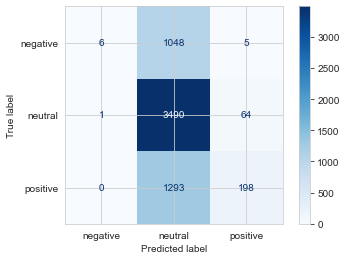

In [40]:
plot_confusion_matrix(NB_clf, X_test_select, y_test_sup, cmap=plt.cm.Blues)
plt.show()

In [41]:
collections.Counter(train_data["sentiment"])

Counter({'neutral': 12659, 'positive': 5428, 'negative': 3715})

In [42]:
#remove some neutral labels
drop_neutral = []
for i in range(len(train_data)):
    if len(drop_neutral) == 8944:
        break
    else:
        if train_data.iloc[i]["sentiment"] == "neutral":
            drop_neutral.append(i)
            
drop_positive = []
for i in range(len(train_data)):
    if len(drop_positive) == 1713:
        break
    else:
        if train_data.iloc[i]["sentiment"] == "positive":
            drop_positive.append(i)
            
drop_index = drop_neutral + drop_positive

In [43]:
drop_index = sorted(drop_index)

In [44]:
feed = train_data.copy()
feed = feed.drop(drop_index)

In [45]:
collections.Counter(feed["sentiment"])

Counter({'negative': 3715, 'positive': 3715, 'neutral': 3715})

### repeat modelling

In [46]:
#separating instance and label for Train
X_train_raw = [x[0] for x in feed[['text']].values]
Y_train = [x[0] for x in feed[['sentiment']].values]

#check the result
print("Train length:",len(X_train_raw))

#separating instance and label for Test
X_test_raw = [x[0] for x in test_data[['text']].values]

#check the result
print("Test length:",len(X_test_raw))


Train length: 11145
Test length: 6099


In [47]:
X_train_clean = []


table = str.maketrans('', '', string.digits)

stop_words = set(stopwords.words('english'))

lemma = WordNetLemmatizer()


for i in range (len(X_train_raw)):
    #remove unnacessary symbles
    soup = BeautifulSoup(X_train_raw[i], "html.parser")
    temp = soup.get_text(separator=" ")
    
    #remove accented characters
    temp = unidecode.unidecode(temp)
    
    #remove contractions
    temp = contractions.fix(temp)

    #remove number
    temp = temp.translate(table)
    
    #remove punctuations
    temp = temp.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation)))

    #remove stop words
    word_tokens = word_tokenize(temp)
    filtered_sentence = []
    for w in word_tokens:
        if w not in stop_words:
            filtered_sentence.append(w)
            
    temp = " ".join(filtered_sentence)
    
    
    #lemmatization
    def pos_tagger(nltk_tag):
        if nltk_tag.startswith('J'):
            return wordnet.ADJ
        elif nltk_tag.startswith('V'):
            return wordnet.VERB
        elif nltk_tag.startswith('N'):
            return wordnet.NOUN
        elif nltk_tag.startswith('R'):
            return wordnet.ADV
        else:         
            return None
        
    pos_tagged = nltk.pos_tag(nltk.word_tokenize(temp)) 
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tagged))
    lemmatized= []
    for word, tag in wordnet_tagged:
        if tag is None:
            lemmatized.append(word)
        else:       
            lemmatized.append(lemma.lemmatize(word, tag))
    temp = " ".join(lemmatized)
    
    
    #remove extra space
    temp = " ".join(temp.strip().split())
    
    #conver to lower
    temp = temp.lower()
    
    X_train_clean.append(temp)
    

In [48]:
X_train_sup, X_test_sup, y_train_sup, y_test_sup = train_test_split(X_train_clean, Y_train, test_size = 0.28, random_state = 42)

In [49]:
#combine words
tfidf_vectorizer2 = TfidfVectorizer(analyzer = 'word', ngram_range = (1, 2))
X_train_tfidf2 = tfidf_vectorizer2.fit_transform(X_train_sup)
X_test_tfidf2 = tfidf_vectorizer2.transform(X_test_sup)

print("Train feature space size (using TFIDF):",X_train_tfidf2.shape)
print("Test feature space size (using TFIDF):",X_test_tfidf2.shape)

Train feature space size (using TFIDF): (8024, 87205)
Test feature space size (using TFIDF): (3121, 87205)


In [50]:
# selector = VarianceThreshold(threshold=0.00001)
# X_train_select = selector.fit_transform(X_train_tfidf)
# X_test_select = selector.transform(X_test_tfidf)
# print(X_train_select.shape, X_test_select.shape)

selector = SelectKBest(chi2, k = 8000)
X_train_select = selector.fit_transform(X_train_tfidf2, y_train_sup)
X_test_select = selector.transform(X_test_tfidf2)
print(X_train_select.shape, X_test_select.shape)

(8024, 8000) (3121, 8000)


In [52]:
#NB 
hyperparams = {
    "alpha" : [0.5, 1, 1.5, 2],
    "fit_prior":[True, False],
}

model = MultinomialNB()
grid_search = GridSearchCV(estimator = model, param_grid = hyperparams, cv = 5, n_jobs = -1, verbose = 3)
grid_search.fit(X_train_select, y_train_sup)
grid_search.best_params_

Fitting 5 folds for each of 8 candidates, totalling 40 fits


{'alpha': 0.5, 'fit_prior': True}

In [53]:
NB_clf = MultinomialNB(alpha=0.5, fit_prior=True)
NB_clf.fit(X_train_select, y_train_sup)
NB_clf.score(X_test_select, y_test_sup)

0.6007689842999039

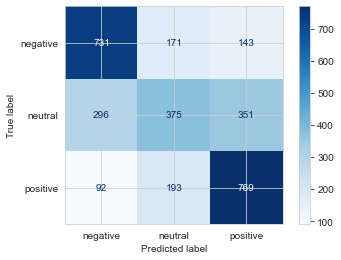

In [54]:
plot_confusion_matrix(NB_clf, X_test_select, y_test_sup, cmap=plt.cm.Blues)
plt.show()

## Prediction

In [55]:
#clean test data
X_test_clean = []


table = str.maketrans('', '', string.digits)

stop_words = set(stopwords.words('english'))

lemma = WordNetLemmatizer()


for i in range (len(X_test_raw)):
    #remove unnacessary symbles
    soup = BeautifulSoup(X_test_raw[i], "html.parser")
    temp = soup.get_text(separator=" ")
    
    #remove accented characters
    temp = unidecode.unidecode(temp)
    
    #remove contractions
    temp = contractions.fix(temp)

    #remove number
    temp = temp.translate(table)
    
    #remove punctuations
    temp = temp.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation)))

    #remove stop words
    word_tokens = word_tokenize(temp)
    filtered_sentence = []
    for w in word_tokens:
        if w not in stop_words:
            filtered_sentence.append(w)
            
    temp = " ".join(filtered_sentence)
    
    
    #lemmatization
    def pos_tagger(nltk_tag):
        if nltk_tag.startswith('J'):
            return wordnet.ADJ
        elif nltk_tag.startswith('V'):
            return wordnet.VERB
        elif nltk_tag.startswith('N'):
            return wordnet.NOUN
        elif nltk_tag.startswith('R'):
            return wordnet.ADV
        else:         
            return None
        
    pos_tagged = nltk.pos_tag(nltk.word_tokenize(temp)) 
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tagged))
    lemmatized= []
    for word, tag in wordnet_tagged:
        if tag is None:
            lemmatized.append(word)
        else:       
            lemmatized.append(lemma.lemmatize(word, tag))
    temp = " ".join(lemmatized)
    
    
    #remove extra space
    temp = " ".join(temp.strip().split())
    
    #conver to lower
    temp = temp.lower()
    
    X_test_clean.append(temp)
    

In [56]:
#vectorize
X_test = tfidf_vectorizer2.transform(X_test_clean)


print("Test feature space size (using TFIDF):",X_test.shape)

#feature select
X_test = selector.transform(X_test)
print(X_test.shape)

Test feature space size (using TFIDF): (6099, 87205)
(6099, 8000)


In [57]:
prediction = NB_clf.predict(X_test)

In [58]:
len(prediction)

6099

In [59]:
result = pd.DataFrame(columns = ["id", "sentiment"])

In [60]:
result["id"] = test_data["id"]
result["sentiment"] = prediction

In [61]:
result.to_csv(r'result1.csv', index = False, header=True)